# Fetal ECG Extraction from Single-Channel Maternal ECG Using Singular Value Decomposition

> Partha Pratim Kanjilal,* Member, ZEEE, Sarbani Palit, Member, ZEEE, and Goutam Saha

Experiments are based on public dataset ADFECGDB

## Outline of the Extraction Procedure

### 1. Separation of the mECG component from the composite signal
The data are first arranged in the form of a matrix $A$ such that the consecutive maternal ECG cycles occupy the consecutive rows, and the peak maternal component lies in the same column. SVD is performed on $A$, and $A_M = u_1 \sigma_1 (v_1)^T$ is separated from $A$, forming $A_{R1}=A-A_M$

### 2. Extraction of the fECG component
The time series formed from the successive rows of $A_{R1}$ will contain the fECG component along with noise; this series is rearranged into a matrix $B$ such that each row contains one fetal ECG cycle, with the peak value lying in the same column. SVD is performed on $B$, from which the most dominant component $u_1 \sigma_1 (v_1)^T$ is extracted, which will give the desiderd fECG component.

## Experimental Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os, wget
import pyedflib  # to read EDF files

import neurokit2 as nk  # for ECG preprocessing and segmentation

from scipy.linalg import svd
from scipy.signal import find_peaks

In [2]:
# # Run this cell only if you need to download the dataset
# !cd .. && mkdir data\raw && cd data\raw
# !python -m wget https://physionet.org/files/adfecgdb/1.0.0/r01.edf -o ../data/raw/r01.edf
# !python -m wget https://physionet.org/files/adfecgdb/1.0.0/r01.edf -o ../data/raw/r04.edf
# !python -m wget https://physionet.org/files/adfecgdb/1.0.0/r01.edf -o ../data/raw/r07.edf
# !python -m wget https://physionet.org/files/adfecgdb/1.0.0/r01.edf -o ../data/raw/r08.edf
# !python -m wget https://physionet.org/files/adfecgdb/1.0.0/r01.edf -o ../data/raw/r10.edf

In [3]:
edf_file = "r01.edf"
edf_path = os.path.join("..", "data", "raw", edf_file)
plot_fig_path = os.path.join("..", "reports", "figures")

In [4]:
# Load EDF file
edf = pyedflib.EdfReader(edf_path)

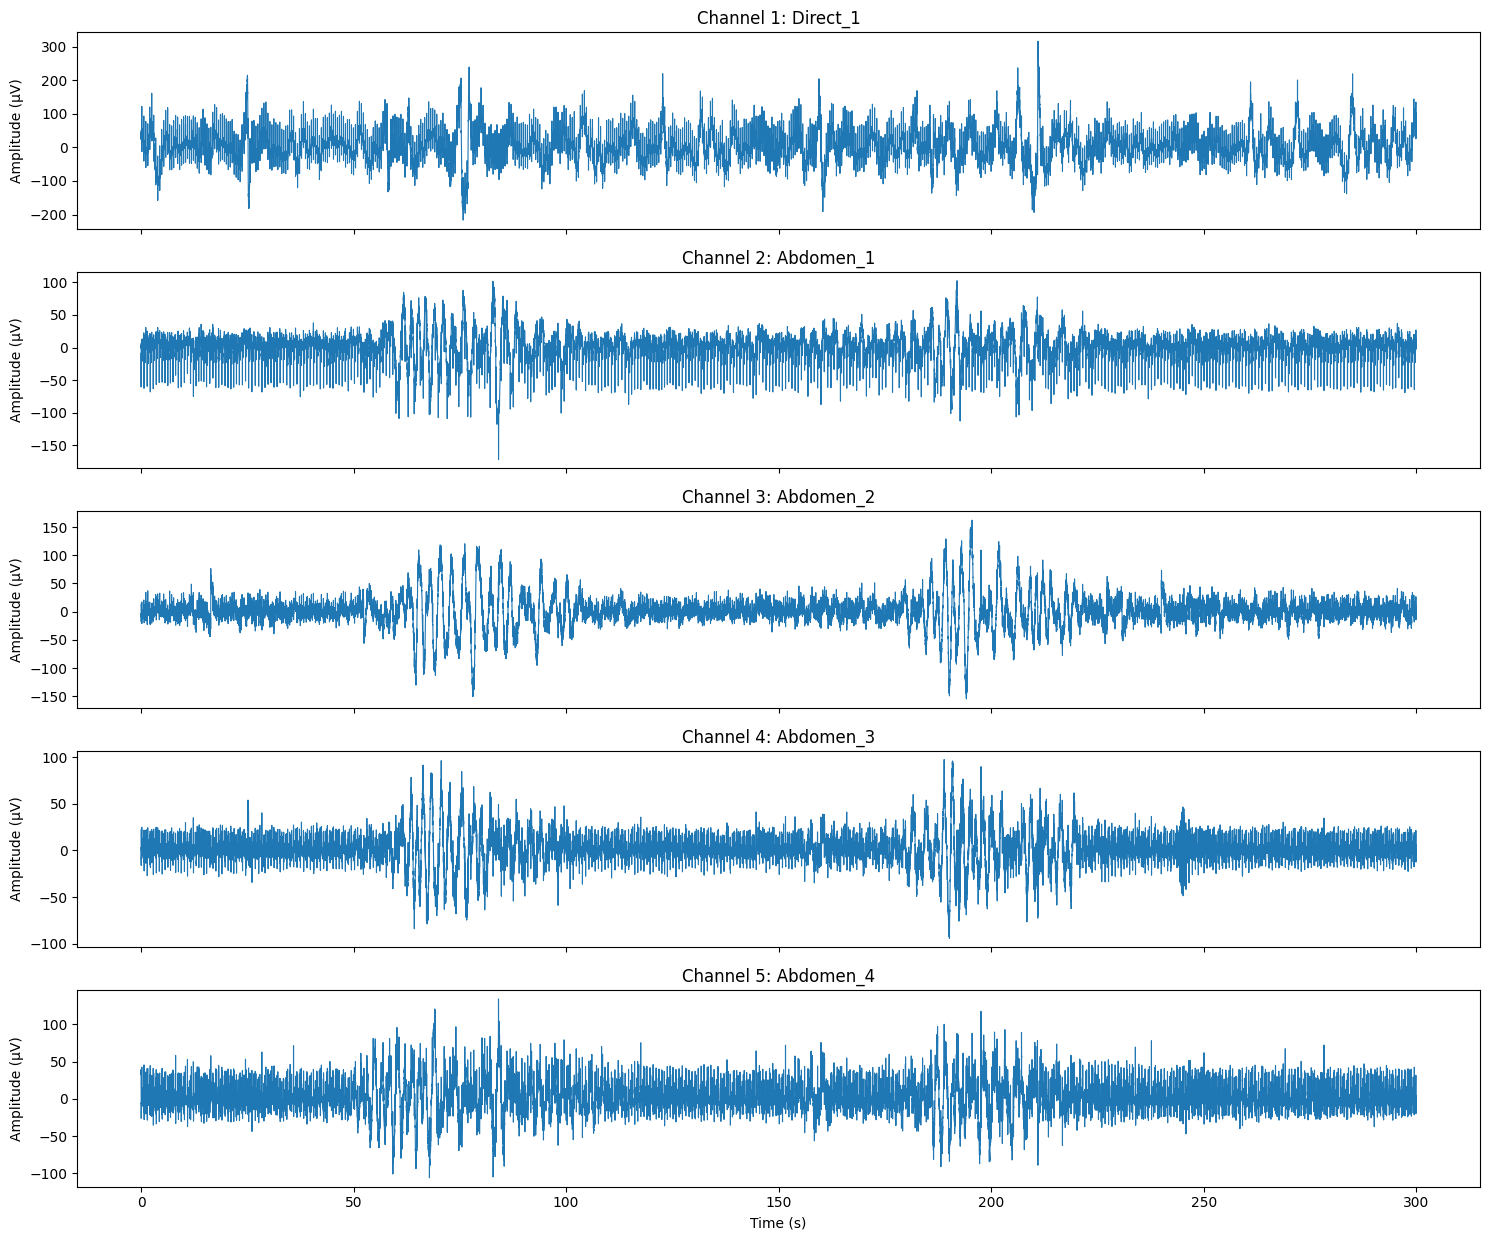

In [5]:
# Get signal info
n_channels = edf.signals_in_file
channel_labels = edf.getSignalLabels()
sampling_rate = edf.getSampleFrequency(0)
signal_duration = edf.getFileDuration()
n_samples = edf.getNSamples()[0]
time_vector = np.linspace(0, signal_duration, n_samples)

# Create subplots
fig, axes = plt.subplots(n_channels, 1, figsize=(15, 2.5 * n_channels), sharex=True)

# Plot each channel with its label
for i in range(n_channels):
    signal = edf.readSignal(i)
    axes[i].plot(time_vector, signal, linewidth=0.8)
    axes[i].set_title(f"Channel {i+1}: {channel_labels[i]}")
    axes[i].set_ylabel("Amplitude (µV)")

axes[-1].set_xlabel("Time (s)")
plt.tight_layout()
plt.savefig(os.path.join(plot_fig_path, 'full-channels-ecg.png'))
plt.show()

In [6]:
direct_signal = edf.readSignal(0)
abdomen_signal = edf.readSignal(1) # 1 = Abdomen_1, 2 = Abdomen_2, 3 = Abdomen_3, 4 = Abdomen_4

# I will not close the file in order to consult different signals later

onsets, durations, labels = edf.readAnnotations() # starting times, duration (in seconds), labels
print("1st onset:", onsets[0]) # the first onset time in seconds
print("1st peak duration:", durations[0]) # -1 if no duration is given
print("1st label:", labels[0]) # the label of the first annotation

1st onset: 0.183
1st peak duration: -1.0
1st label: QRS


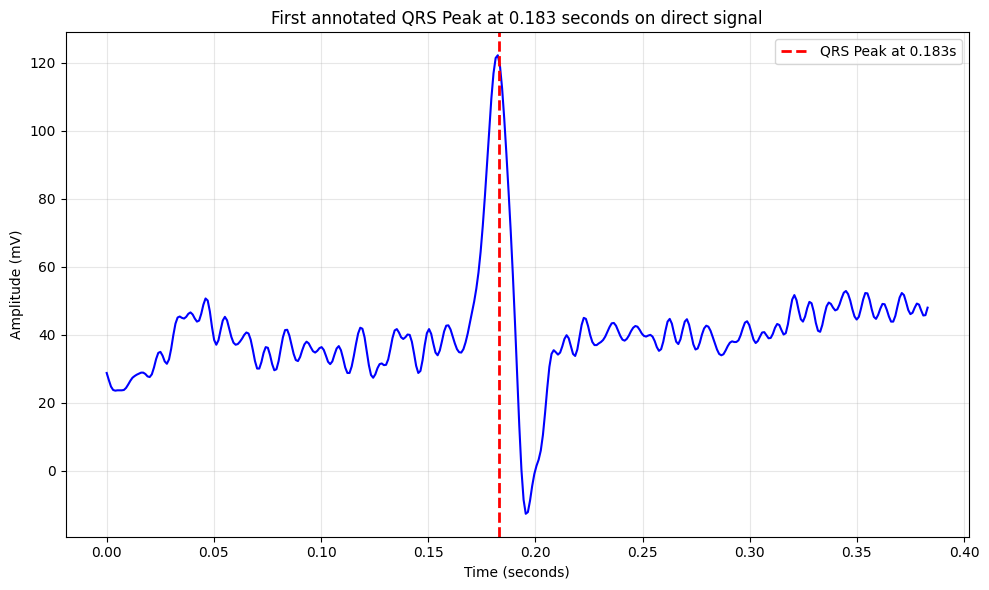

In [7]:
# Let's plot the first QRS peak
first_onset = onsets[0]
first_label = labels[0]

window_duration = 0.2  # seconds around the peak (supposed)
start_time = max(0, first_onset - window_duration)
end_time = first_onset + window_duration

# Convert to sample indices
start_sample = int(start_time * sampling_rate)
end_sample = int(end_time * sampling_rate)

# Extract the signal segment
signal_segment = direct_signal[start_sample:end_sample]
time_segment = np.linspace(start_time, end_time, len(signal_segment))

# Plot
plt.figure(figsize=(10, 6))
plt.plot(time_segment, signal_segment, 'b-', linewidth=1.5)
plt.axvline(x=first_onset, color='r', linestyle='--', linewidth=2, label=f'QRS Peak at {first_onset:.3f}s')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude (mV)')
plt.title(f'First annotated QRS Peak at {first_onset:.3f} seconds on direct signal')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(plot_fig_path, 'first-qrs-peak.png'))
plt.show()

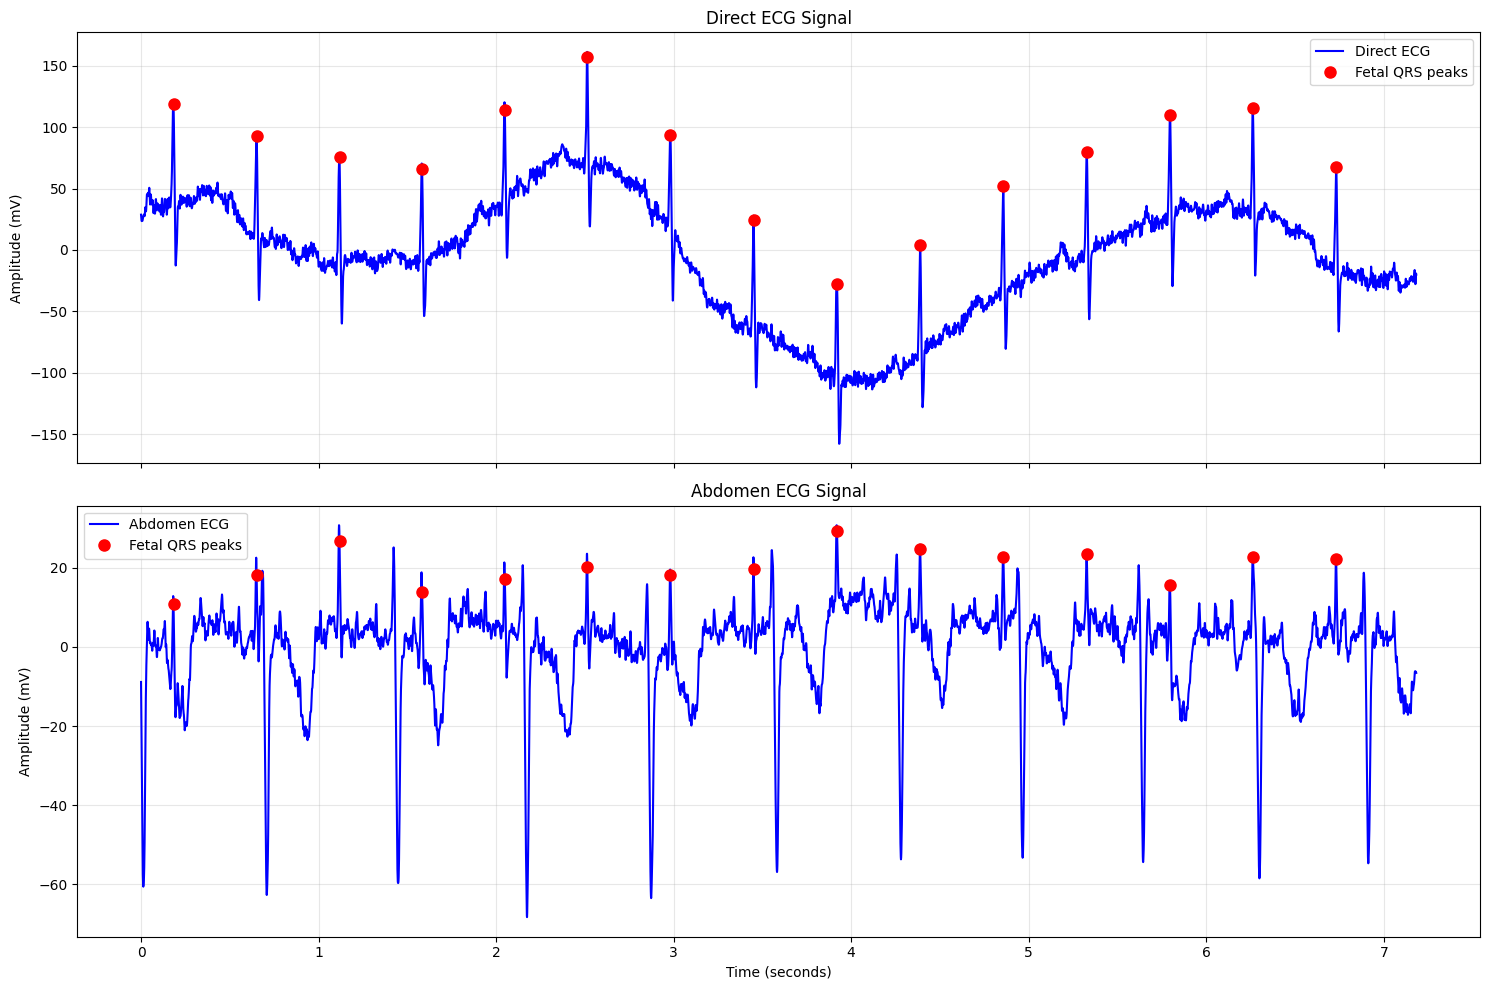

In [8]:
window_duration = 7.0 # Let's use 5 seconds window
start_time = max(0, first_onset - window_duration)
end_time = first_onset + window_duration

# Convert to sample indices
start_sample = int(start_time * sampling_rate)
end_sample = int(end_time * sampling_rate)

# Extract the signal segment
direct_signal_segment = direct_signal[start_sample:end_sample]
abdomen_signal_segment = abdomen_signal[start_sample:end_sample]
direct_time_segment = np.linspace(start_time, end_time, len(direct_signal_segment))
abdomen_time_segment = np.linspace(start_time, end_time, len(abdomen_signal_segment))

# Get the onsets within the specified time window and interpolate their values
onsets_in_window = onsets[(onsets >= start_time) & (onsets <= end_time)]
direct_onset_values = np.interp(onsets_in_window, direct_time_segment, direct_signal_segment)
abdomen_onset_values = np.interp(onsets_in_window, abdomen_time_segment, abdomen_signal_segment)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

# Direct signal
ax1.plot(direct_time_segment, direct_signal_segment, 'b-', linewidth=1.5, label='Direct ECG')
ax1.plot(onsets_in_window, direct_onset_values, 'ro', markersize=8, label="Fetal QRS peaks")
ax1.set_ylabel('Amplitude (mV)')
ax1.set_title(f'Direct ECG Signal')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Abdomen signal
ax2.plot(abdomen_time_segment, abdomen_signal_segment, 'b-', linewidth=1.5, label='Abdomen ECG')
ax2.plot(onsets_in_window, abdomen_onset_values, 'ro', markersize=8, label="Fetal QRS peaks")
ax2.set_xlabel('Time (seconds)')
ax2.set_ylabel('Amplitude (mV)')
ax2.set_title(f'Abdomen ECG Signal')
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.savefig(os.path.join(plot_fig_path, 'direct-and-abdomen-segments.png'))
plt.show()

In [9]:
def interpolate_segment(y, target_length):
    original_length = len(y)
    x = np.zeros(target_length)

    for j in range(target_length):
        r_j = (j) * (original_length - 1) / (target_length - 1) + 1  # r_j ∈ [1, original_length]
        j_star = int(np.floor(r_j)) - 1  # 0-based index
        delta = r_j - (j_star + 1)

        if j_star + 1 < original_length:
            x[j] = y[j_star] + (y[j_star + 1] - y[j_star]) * delta
        else:
            x[j] = y[j_star]  # Edge case: last value
    return x

def build_matrix_interpolated(signal, estimated_starts, target_length):
    segments = []
    for i in range(len(estimated_starts) - 1):
        start = estimated_starts[i]
        end = estimated_starts[i + 1]
        segment = signal[start:end]
        interpolated = interpolate_segment(segment, target_length)
        segments.append(interpolated)

    return np.array(segments)

def build_matrix(signal, row_length):
    # Calculate the number of rows based on the signal length and row_length
    n_rows = len(signal) // row_length
    
    # For each row, take row_length samples from the signal (from i*row_length to (i+1)*row_length)
    # if i = 0, it takes signal[0*row_length:(0+1)*row_length]
    # if i = 1, it takes signal[1*row_length:(1+1)*row_length], etc.
    matrix = np.array([signal[i*row_length:(i+1)*row_length] for i in range(n_rows)])
    return matrix

def build_matrix_ver2(signal, row_length):
    # Calculate the number of rows based on the signal length and row_length
    n_rows = len(signal) // row_length
    
    # For each row, take row_length samples from the signal (from i*row_length to (i+1)*row_length)
    # if i = 1, it takes signal[1*row_length/2:(1+1)*row_length/2]
    matrix = np.array([signal[i*row_length//2:(i+1)*row_length//2] for i in range(1, n_rows)])
    return matrix

def svr_spectrum(signal, n_min, n_max):
    sv_ratios = []  # To store singular value ratios
    n_values = range(n_min, n_max + 1)  # Generate a range of n values from n_min to n_max
    
    for n in n_values:
        # Build the matrix with the current row_length value n
        A = build_matrix(signal, n)
        if A.shape[0] < 2 or A.shape[1] < 2:
            sv_ratios.append(0)
            continue
        
        U, S, VT = np.linalg.svd(A, full_matrices=False)
        if len(S) >= 2 and S[1] != 0:
            # Calculate the ratio of sigma_2 on sigma
            sv_ratios.append(S[1] / S[0])
        else:
            sv_ratios.append(0)
    
    return list(n_values), sv_ratios

# Removed sliding window SVD extraction from here

To convert period length (in samples) to heart rate in beats per minute (bpm), we can use this formula:

$$n = \frac{samples/second \times 60 seconds/minute}{beats/minute}$$

$$n_{max} = \frac{1000 \times 60}{50} = 1200$$
$$n_{min} = \frac{1000 \times 60}{160} = 375$$

Optimal period length: 716 samples (83.80 bpm)


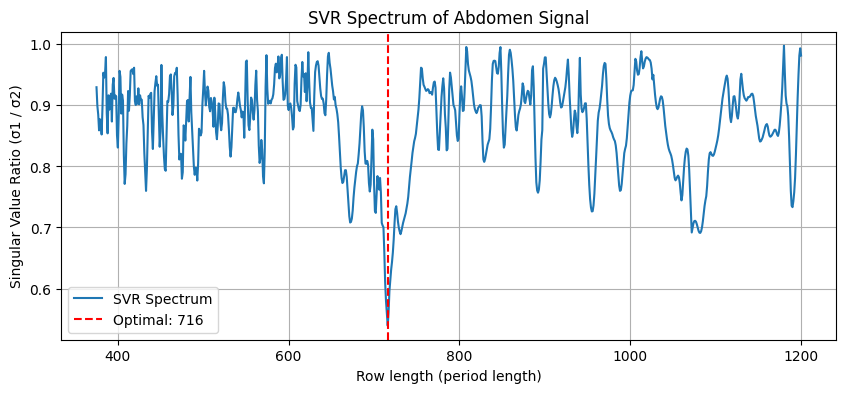

In [10]:
# Parameters
n_min = 375
n_max = 1200

# Compute SVR spectrum
n_vals, svrs = svr_spectrum(abdomen_signal_segment, n_min, n_max)

# Find optimal period (max SVR)
mecg_optimal_period = n_vals[np.argmin(svrs)]
optimal_bpm = (sampling_rate * 60) / mecg_optimal_period
print(f"Optimal period length: {mecg_optimal_period} samples ({optimal_bpm:.2f} bpm)")

# Plot SVR spectrum
plt.figure(figsize=(10, 4))
plt.plot(n_vals, svrs, label='SVR Spectrum')
plt.axvline(mecg_optimal_period, color='red', linestyle='--', label=f'Optimal: {mecg_optimal_period}')
plt.xlabel("Row length (period length)")
plt.ylabel("Singular Value Ratio (σ1 / σ2)")
plt.title("SVR Spectrum of Abdomen Signal")
plt.grid(True)
plt.legend()
plt.show()

From now on, we will always use <code>direct_1_signal</code> as the fECG ground truth and <code>abdomen_signal</code> as one of the four composite ECGs which contains fECG and mECG together. In order to change the abdomen signal, put a number between 1 and 4 in <code>abdomen_signal = edf.readSignal(1)</code> at the beginning of the previous script.

## Method #1 and #2
The most commonly occurring period length for the mECG is considered to be the row lenght ($n$) of the data matrix $A$. The consecutive periods with respect to mECG cycles are aligned into the consecutive rows of $A$, and linearly interpolated data are used for the periods shorter than n. The row length of matrix $B$ is also decided similarly with respect to the fECG cycles. The part of the data in $u_1 \sigma_1 (v_1)^T$ that corresponds to the interpolated data in $A$ or $B$ is eliminated while forming the extracted mECG and the fECG series.

The most likely periodic length (in terms of energy) of the most dominant periodic component present in the signal is considered to be the row lengths of the data matrices $A$ and $B$. The SVR spectrum of the composite maternal ECG signal is used to determine the period length (say $n$) of the mECG component in the composite signal. The periodic segments which are not equal to $n$ in length, are compressed or expanded to the length $n$ as follows.

The data segment $y(1), y(2), ..., y(n^*)$, can be replaced by the set $x(1), x(2), ..., x(n)$ where $n \ne n^*$, using the transformation

$$x(j) = y(j^*) + (y(j^* + 1) - y(j^*))(r_j - j^*)$$

where $r_j = \frac{(j - 1)(n^* - 1)}{(n - 1) + 1}$, and $j^*$ is the integral part of $r_j$. Thus the successive (pseudo-)periods of the composite ECG series $\{y( \cdot )\}$ are converted into data lengths having the same period length $n$, which are now aligned in the rows of the matrix $A$. Appropriate reverse transformation is performed on the data at the time of reconstruction of the extracted mECG series.

The period length of the fECG component is determined from the SVR spectrum of the residual series. The subsequent steps for arranging data into $B$ are the same as above.

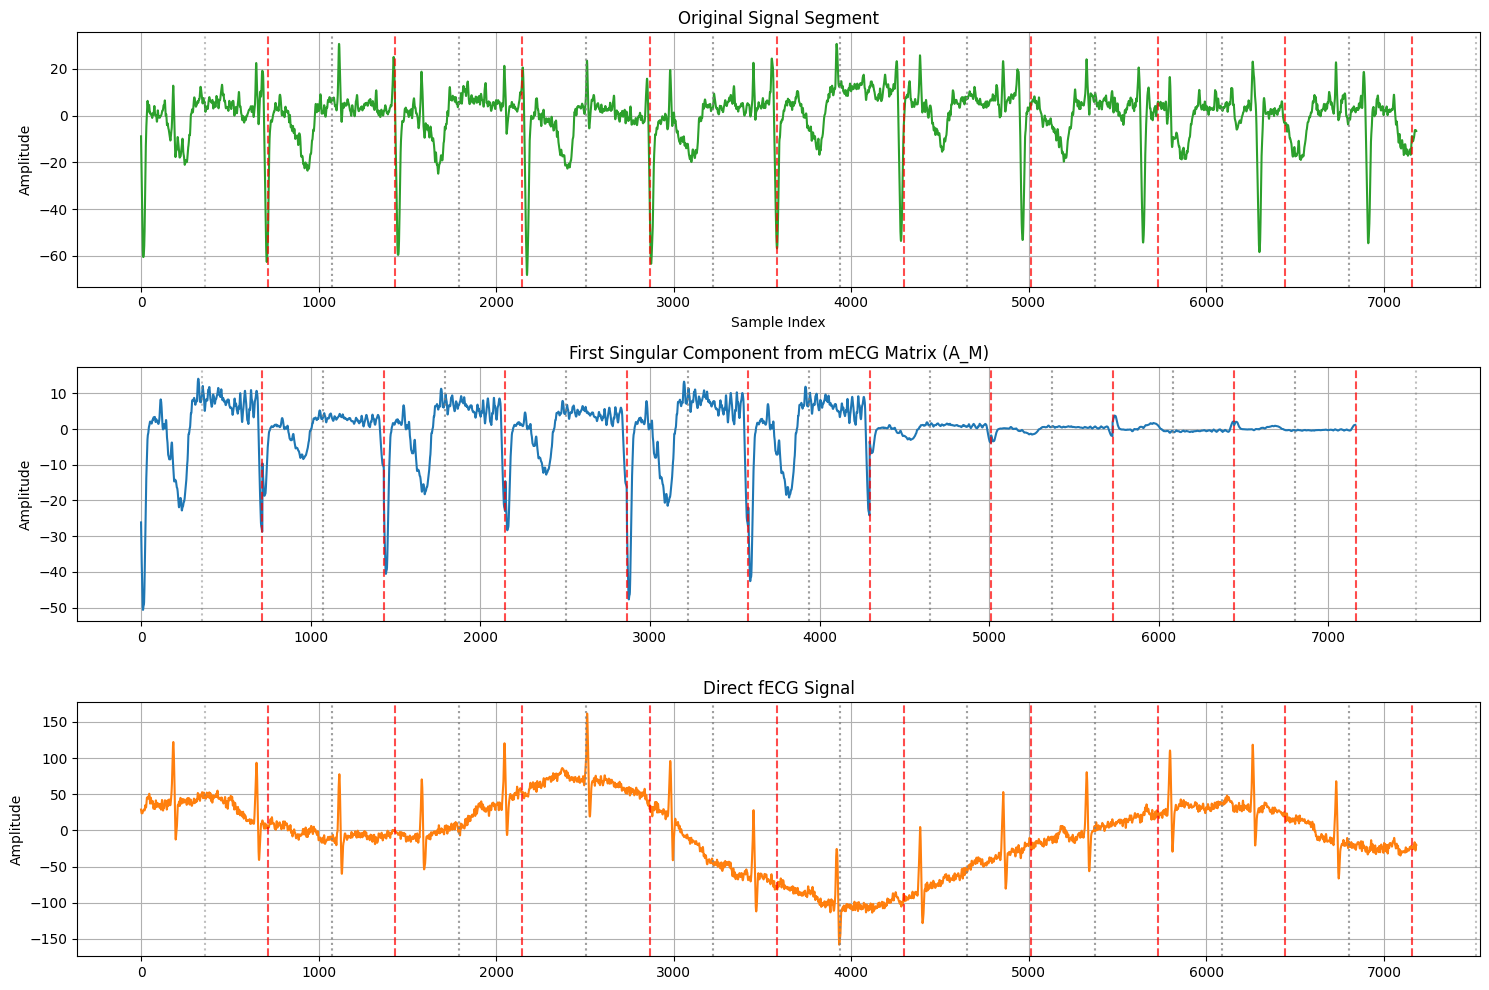

In [11]:
peaks, _ = find_peaks(abdomen_signal_segment, distance=sampling_rate * 0.5)  # assume ~120 BPM

# A = build_matrix_interpolated(abdomen_signal_segment, peaks, mecg_optimal_period)
# A = build_matrix_ver2(abdomen_signal_segment, mecg_optimal_period)
A = build_matrix(abdomen_signal_segment, mecg_optimal_period)
U, S, VT = np.linalg.svd(A, full_matrices=False)

u1_A = U[:, 0].reshape(-1, 1)  # First left singular vector
sigma1_A = S[0]  # First singular value
v1_A = VT[0, :].reshape(-1, 1)  # First right singular vector

A_M = np.dot(u1_A, sigma1_A * v1_A.T)  # Reconstructed matrix using first singular value and vector
A_M_flat = A_M.flatten()
A_residual = A - A_M  # Residual matrix after removing first component
A_residual_flat = A_residual.flatten()

# Plot
plt.figure(figsize=(15, 10))

# Subplot 1: Residual of A (A - A_M)
plt.subplot(3, 1, 1)
plt.plot(abdomen_signal_segment, color='tab:green')
for x in range(mecg_optimal_period, len(abdomen_signal_segment), mecg_optimal_period):
    plt.axvline(x=x, color='red', linestyle='--', alpha=0.7)
    plt.axvline(x=x - mecg_optimal_period // 2, color='gray', linestyle=':', alpha=0.5)
    plt.axvline(x=x + mecg_optimal_period // 2, color='gray', linestyle=':', alpha=0.5)
plt.title("Original Signal Segment")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.grid(True)

# Subplot 2: First Singular Component (fECG extracted)
plt.subplot(3, 1, 2)
plt.plot(A_M_flat, color='tab:blue')
for x in range(mecg_optimal_period, len(abdomen_signal_segment), mecg_optimal_period):
    plt.axvline(x=x, color='red', linestyle='--', alpha=0.7)
    plt.axvline(x=x - mecg_optimal_period // 2, color='gray', linestyle=':', alpha=0.5)
    plt.axvline(x=x + mecg_optimal_period // 2, color='gray', linestyle=':', alpha=0.5)
plt.title("First Singular Component from mECG Matrix (A_M)")
plt.ylabel("Amplitude")
plt.grid(True)

# Subplot 3: Direct fECG Signal (Reference)
plt.subplot(3, 1, 3)
plt.plot(direct_signal_segment, color='tab:orange')
for x in range(mecg_optimal_period, len(abdomen_signal_segment), mecg_optimal_period):
    plt.axvline(x=x, color='red', linestyle='--', alpha=0.7)
    plt.axvline(x=x - mecg_optimal_period // 2, color='gray', linestyle=':', alpha=0.5)
    plt.axvline(x=x + mecg_optimal_period // 2, color='gray', linestyle=':', alpha=0.5)
plt.title("Direct fECG Signal")
plt.ylabel("Amplitude")
plt.grid(True)

plt.tight_layout()
plt.show()

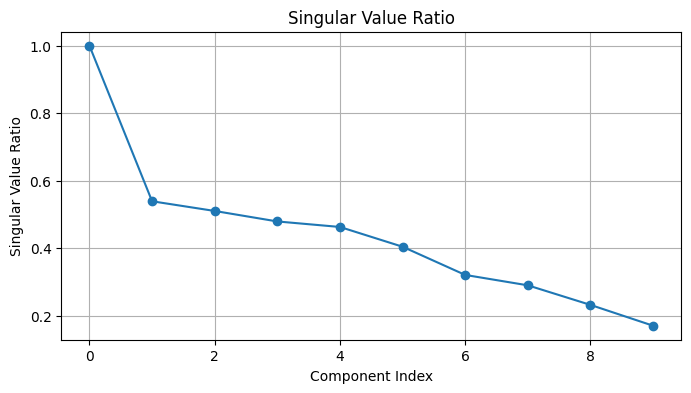

In [12]:
# Compute the singular value ratio (each singular value divided by the first)
singular_value_ratio = S / S[0]

# Plot the singular value ratio
plt.figure(figsize=(8, 4))
plt.plot(singular_value_ratio, marker='o')
plt.title('Singular Value Ratio')
plt.xlabel('Component Index')
plt.ylabel('Singular Value Ratio')
plt.grid(True)
plt.show()

Optimal period length: 665 samples (90.23 bpm)


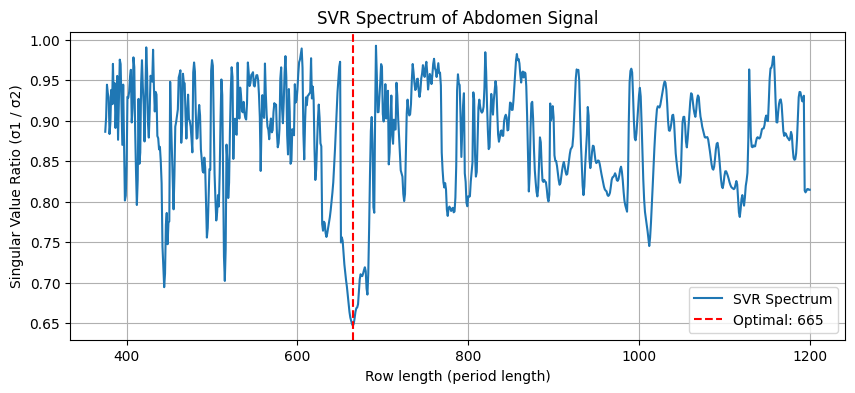

In [13]:
# Parameters
n_min = 375
n_max = 1200

# Compute SVR spectrum
n_vals, svrs = svr_spectrum(A_residual_flat, n_min, n_max)

# Find optimal period (max SVR)
fecg_optimal_period = n_vals[np.argmin(svrs)]
optimal_bpm = (sampling_rate * 60) / fecg_optimal_period
print(f"Optimal period length: {fecg_optimal_period} samples ({optimal_bpm:.2f} bpm)")

# Plot SVR spectrum
plt.figure(figsize=(10, 4))
plt.plot(n_vals, svrs, label='SVR Spectrum')
plt.axvline(fecg_optimal_period, color='red', linestyle='--', label=f'Optimal: {fecg_optimal_period}')
plt.xlabel("Row length (period length)")
plt.ylabel("Singular Value Ratio (σ1 / σ2)")
plt.title("SVR Spectrum of Abdomen Signal")
plt.grid(True)
plt.legend()
plt.show()

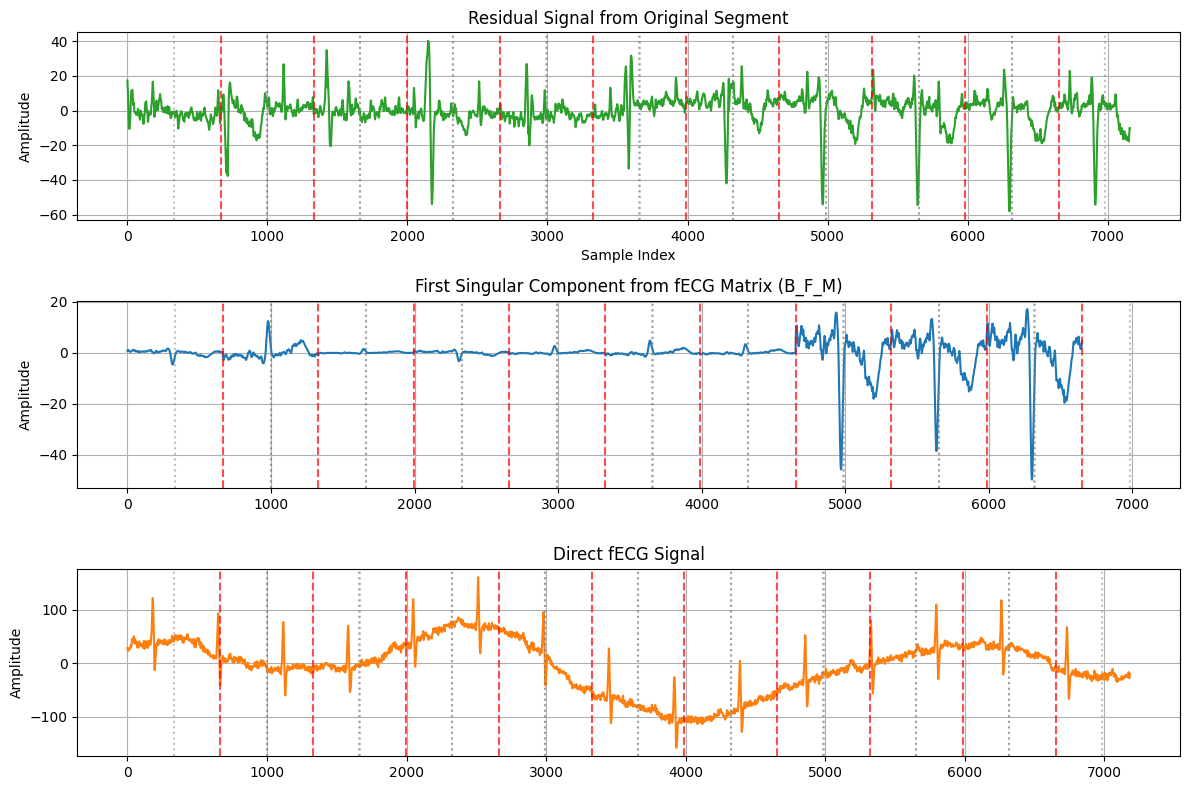

In [14]:
peaks, _ = find_peaks(A_residual_flat, distance=sampling_rate * 0.5)  # assume ~120 BPM

# B = build_matrix_interpolated(A_residual_flat, peaks, fecg_optimal_period)
# B = build_matrix_ver2(A_residual_flat, fecg_optimal_period)
B = build_matrix(A_residual_flat, fecg_optimal_period)
U, S, VT = np.linalg.svd(B, full_matrices=False)

u1_B = U[:, 0].reshape(-1, 1)  # First left singular vector
sigma1_B = S[0]  # First singular value
v1_B = VT[0, :].reshape(-1, 1)  # First right singular vector

B_F = np.dot(u1_B, sigma1_B * v1_B.T)  # Reconstructed matrix using first singular value and vector
B_F_flat = B_F.flatten()
B_residual = B - B_F  # Residual matrix after removing first component
B_residual_flat = B_residual.flatten()

# Plot
plt.figure(figsize=(12, 8))

# Subplot 1: Original Signal Segment
plt.subplot(3, 1, 1)
plt.plot(A_residual_flat, color='tab:green')
for x in range(fecg_optimal_period, len(abdomen_signal_segment), fecg_optimal_period):
    plt.axvline(x=x, color='red', linestyle='--', alpha=0.7)
    plt.axvline(x=x - fecg_optimal_period // 2, color='gray', linestyle=':', alpha=0.5)
    plt.axvline(x=x + fecg_optimal_period // 2, color='gray', linestyle=':', alpha=0.5)
plt.title("Residual Signal from Original Segment")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.grid(True)

# Subplot 2: First Singular Component (fECG extracted)
plt.subplot(3, 1, 2)
plt.plot(B_F_flat, color='tab:blue')
for x in range(fecg_optimal_period, len(abdomen_signal_segment), fecg_optimal_period):
    plt.axvline(x=x, color='red', linestyle='--', alpha=0.7)
    plt.axvline(x=x - fecg_optimal_period // 2, color='gray', linestyle=':', alpha=0.5)
    plt.axvline(x=x + fecg_optimal_period // 2, color='gray', linestyle=':', alpha=0.5)
plt.title("First Singular Component from fECG Matrix (B_F_M)")
plt.ylabel("Amplitude")
plt.grid(True)

# Subplot 3: Direct fECG Signal (Reference)
plt.subplot(3, 1, 3)
plt.plot(direct_signal_segment, color='tab:orange')
for x in range(fecg_optimal_period, len(abdomen_signal_segment), fecg_optimal_period):
    plt.axvline(x=x, color='red', linestyle='--', alpha=0.7)
    plt.axvline(x=x - fecg_optimal_period // 2, color='gray', linestyle=':', alpha=0.5)
    plt.axvline(x=x + fecg_optimal_period // 2, color='gray', linestyle=':', alpha=0.5)
plt.title("Direct fECG Signal")
plt.ylabel("Amplitude")
plt.grid(True)

plt.tight_layout()
plt.show()

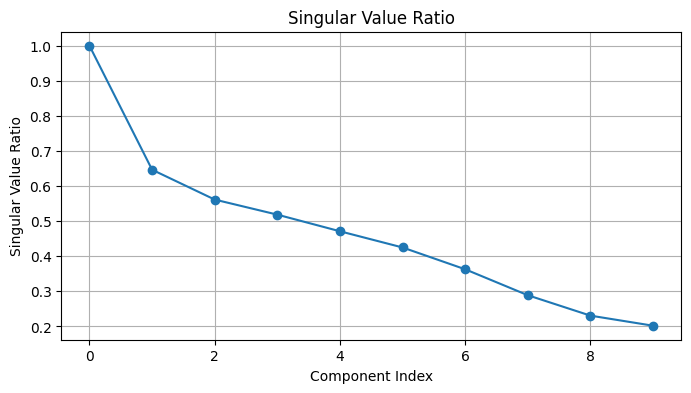

In [15]:
# Compute the singular value ratio (each singular value divided by the first)
singular_value_ratio = S / S[0]

# Plot the singular value ratio
plt.figure(figsize=(8, 4))
plt.plot(singular_value_ratio, marker='o')
plt.title('Singular Value Ratio')
plt.xlabel('Component Index')
plt.ylabel('Singular Value Ratio')
plt.grid(True)
plt.show()

## Method #3
Once the $m \times n$ data matrix $A$ is formed, an $m_1 \times n$ ($m_1 \le m$) matrix $\tilde{A}$ is assumed to move over $A$ such that the first row is dropped and a new row is appended for successive locations of the window. $\tilde{A}$ is SV-decomposed, and the last row of $u_1 \sigma_1 (v_1)^T$ is assumed to be the extracted mECG component corresponding to the last row of $\tilde{A}$, which is subtracted from the original composite ECG series. The residual series id arranged into $B$, from which the fECG component is extracted the same way as the mECG component. This scheme is particularly applicable when sufficient amount of data are available.

## Using neurokit2

In this section, we will perform all the operations using neurokit2, a Python library which provides different functions for ECGs.


Successfully opened EDF data file.
Number of channels: 5
Channel names: ['Direct_1', 'Abdomen_1', 'Abdomen_2', 'Abdomen_3', 'Abdomen_4']
Sampling frequency: 1000 Hz
Total samples per channel: 300000
Selected channel for processing: 'Abdomen_1'
Loaded signal with 5000 samples at 1000 Hz.


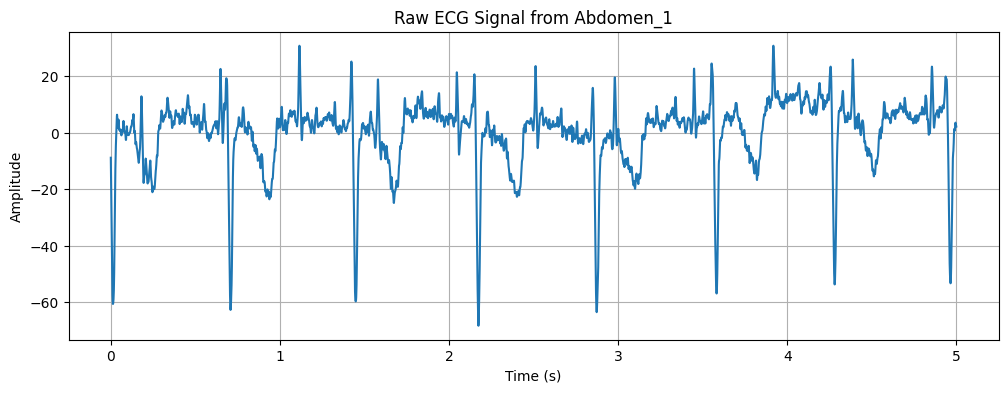

In [16]:

n_channels = edf.signals_in_file
ch_names = edf.getSignalLabels()
fs = int(edf.getSampleFrequency(0)) # Get sample freq of the first channel
n_samples_total = edf.getNSamples()[0] # Get number of samples in the first channel

print("\nSuccessfully opened EDF data file.")
print(f"Number of channels: {n_channels}")
print(f"Channel names: {ch_names}")
print(f"Sampling frequency: {fs} Hz")
print(f"Total samples per channel: {n_samples_total}")

signals_list = [edf.readSignal(i) for i in range(n_channels)]
signals = np.array(signals_list).T # (samples, channels)

try:
    maternal_ecg_channel_index = ch_names.index('Abdomen_1')
except ValueError:
    print("Warning: 'Abdomen_1' channel not found. Please identify the correct channel name.")
    maternal_ecg_channel_index = 0
    print(f"Using channel {maternal_ecg_channel_index} ('{ch_names[maternal_ecg_channel_index]}') as the raw signal.")

raw_signal = signals[:, maternal_ecg_channel_index][0:5000]
sampling_rate = fs
time = np.linspace(0, len(raw_signal)/sampling_rate, len(raw_signal), endpoint=False)

print(f"Selected channel for processing: '{ch_names[maternal_ecg_channel_index]}'")
print(f"Loaded signal with {len(raw_signal)} samples at {sampling_rate} Hz.")

# Plot the cleaned signal
plt.figure(figsize=(12, 4))
plt.plot(time, raw_signal)
plt.title(f'Raw ECG Signal from {ch_names[maternal_ecg_channel_index]}')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

signals_matrix shape: (712, 7)


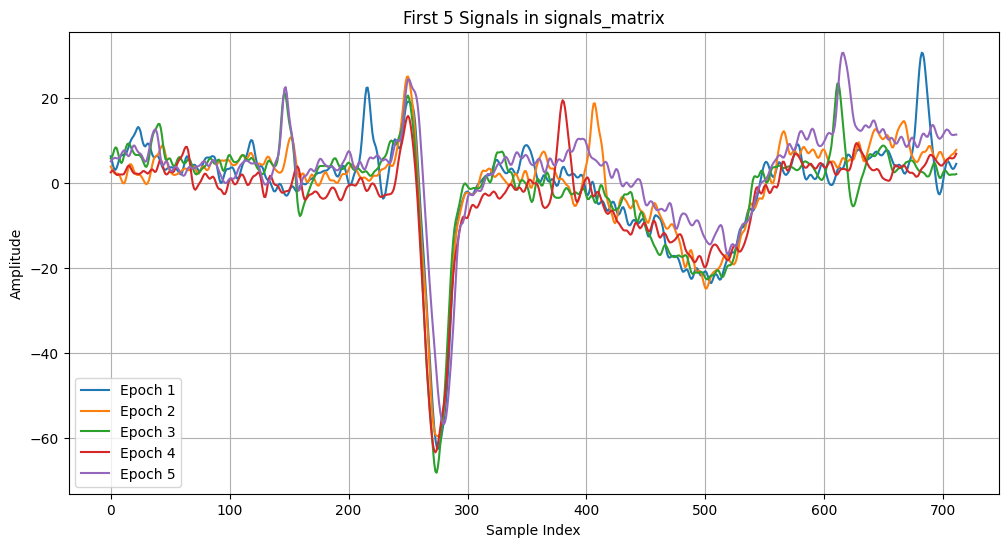

In [17]:
qrs_epochs = nk.ecg_segment(raw_signal, rpeaks=None, sampling_rate=1000, show=False)

# Build a matrix of signals from all epochs (each column is an epoch)
epoch_keys = list(qrs_epochs.keys())
num_epochs = len(epoch_keys)
epoch_length = qrs_epochs[epoch_keys[0]].shape[0]

# Preallocate matrix
signals_matrix = np.zeros((epoch_length, num_epochs))

for i, key in enumerate(epoch_keys):
    signals_matrix[:, i] = qrs_epochs[key]['Signal'].values

print(f"signals_matrix shape: {signals_matrix.shape}")

plt.figure(figsize=(12, 6))
for idx in range(5):
    plt.plot(signals_matrix[:, idx], label=f'Epoch {idx+1}')
plt.title('First 5 Signals in signals_matrix')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()

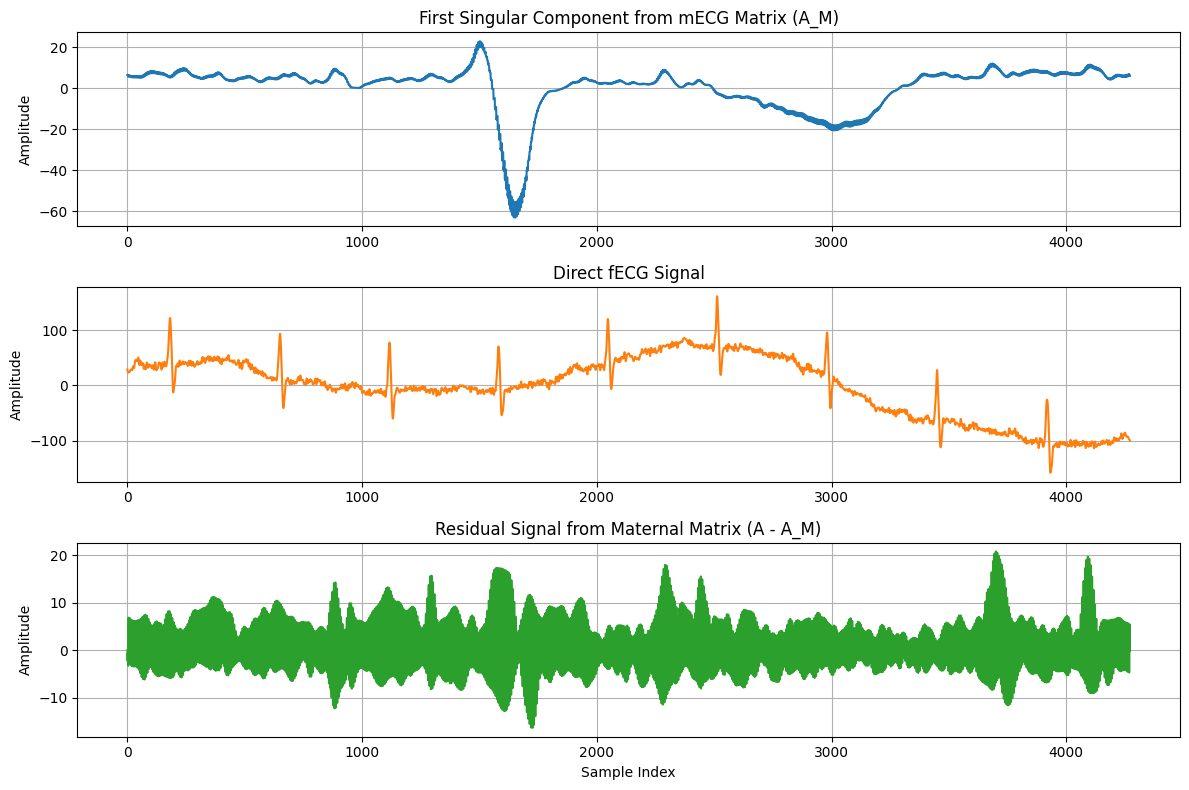

In [18]:
A = signals_matrix[:, ~np.isnan(signals_matrix).any(axis=0)]
U, S, VT = np.linalg.svd(A, full_matrices=False)

u1_A = U[:, 0].reshape(-1, 1)  # First left singular vector
sigma1_A = S[0]  # First singular value
v1_A = VT[0, :].reshape(-1, 1)  # First right singular vector

A_M = np.dot(u1_A, sigma1_A * v1_A.T)  # Reconstructed matrix using first singular value and vector
A_M_flat = A_M.flatten()
A_residual = A - A_M  # Residual matrix after removing first component
A_residual_flat = A_residual.flatten()

# Optional: Trim Direct_1_signal to match A_M_flat length
min_len = min(len(direct_signal), len(A_M_flat))
A_M_flat = A_M_flat[:min_len]
direct_1_trimmed = direct_signal[:min_len]
A_residual_flat = A_residual_flat[:min_len]

# Plot
plt.figure(figsize=(12, 8))

# Subplot 1: First Singular Component (fECG extracted)
plt.subplot(3, 1, 1)
plt.plot(A_M_flat, color='tab:blue')
plt.title("First Singular Component from mECG Matrix (A_M)")
plt.ylabel("Amplitude")
plt.grid(True)

# Subplot 2: Direct fECG Signal (Reference)
plt.subplot(3, 1, 2)
plt.plot(direct_1_trimmed, color='tab:orange')
plt.title("Direct fECG Signal")
plt.ylabel("Amplitude")
plt.grid(True)

# Subplot 3: Residual of A (A - A_M)
plt.subplot(3, 1, 3)
plt.plot(A_residual_flat, color='tab:green')
plt.title("Residual Signal from Maternal Matrix (A - A_M)")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.grid(True)

plt.tight_layout()
plt.show()